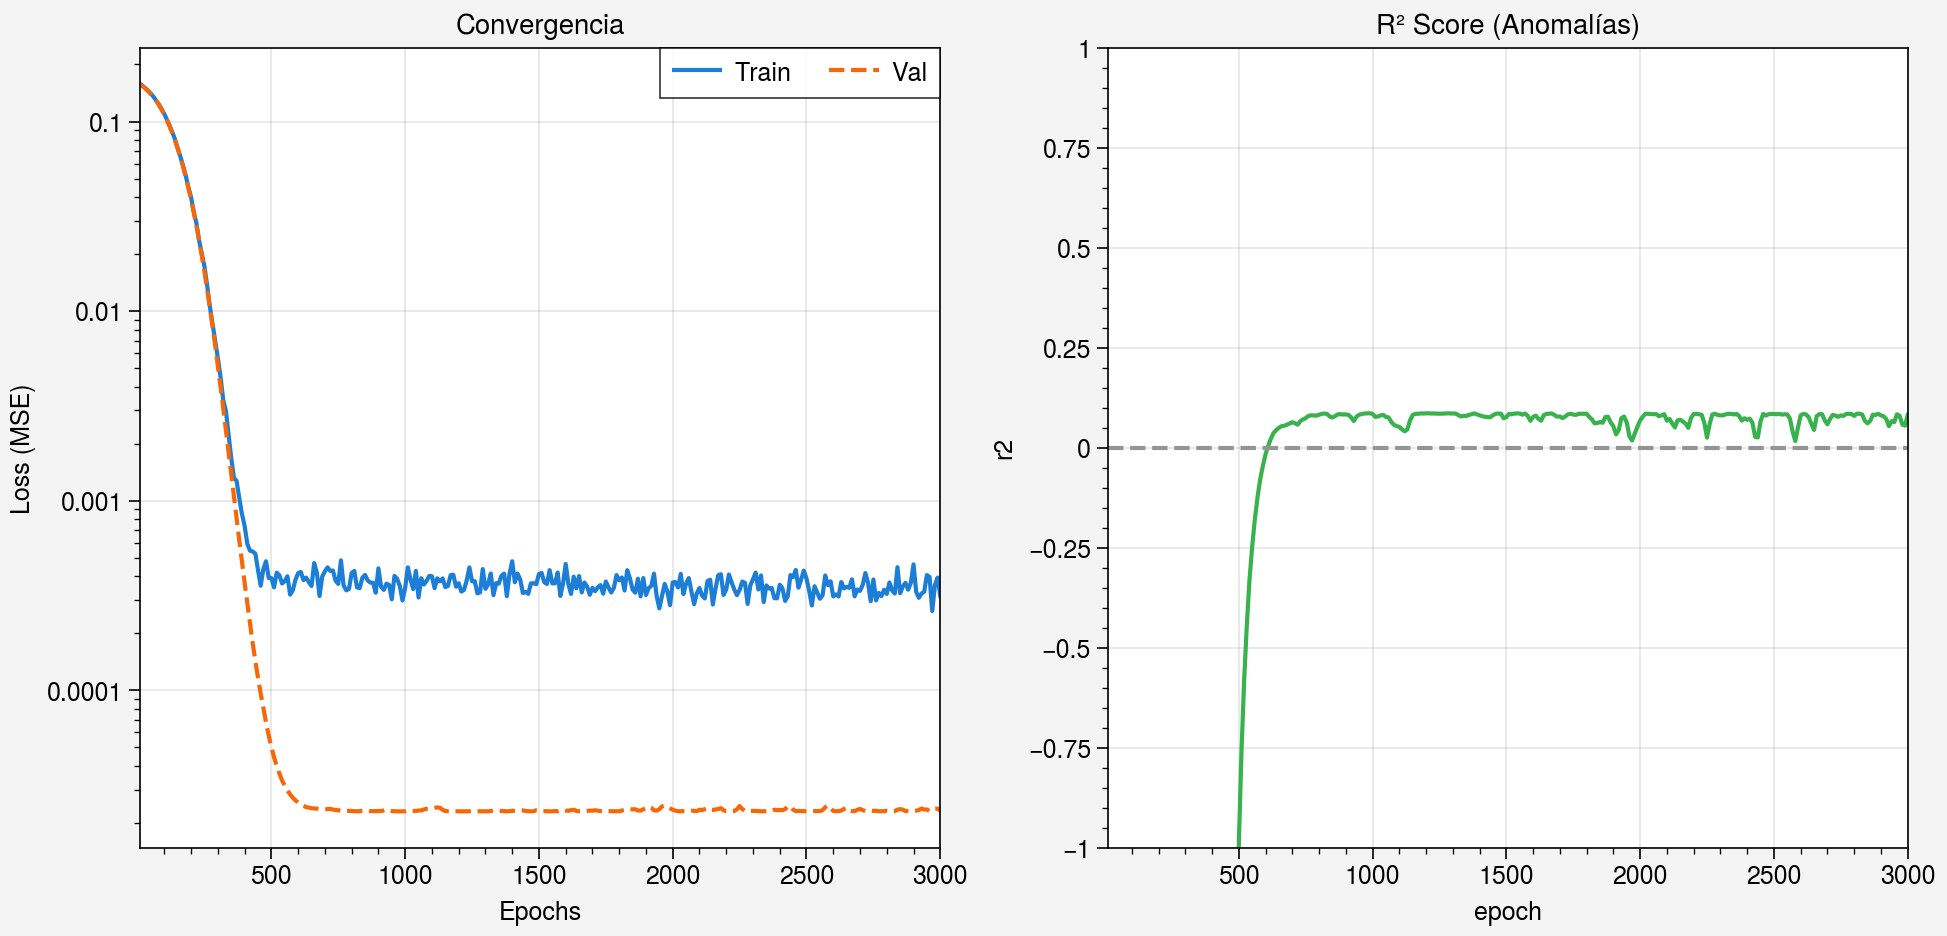

Cargando datos desde: /mnt/beegfs/home/caliste/Proyecto_Clima_ML/data/processed/val.pt


/tmp/ipykernel_1903382/2517031593.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATA_FILE)
/tmp/ipykernel_1903382/2517031593.py:64: FutureWarning: Y

Ejecutando prediccion...
Datos reconstruidos correctamente.


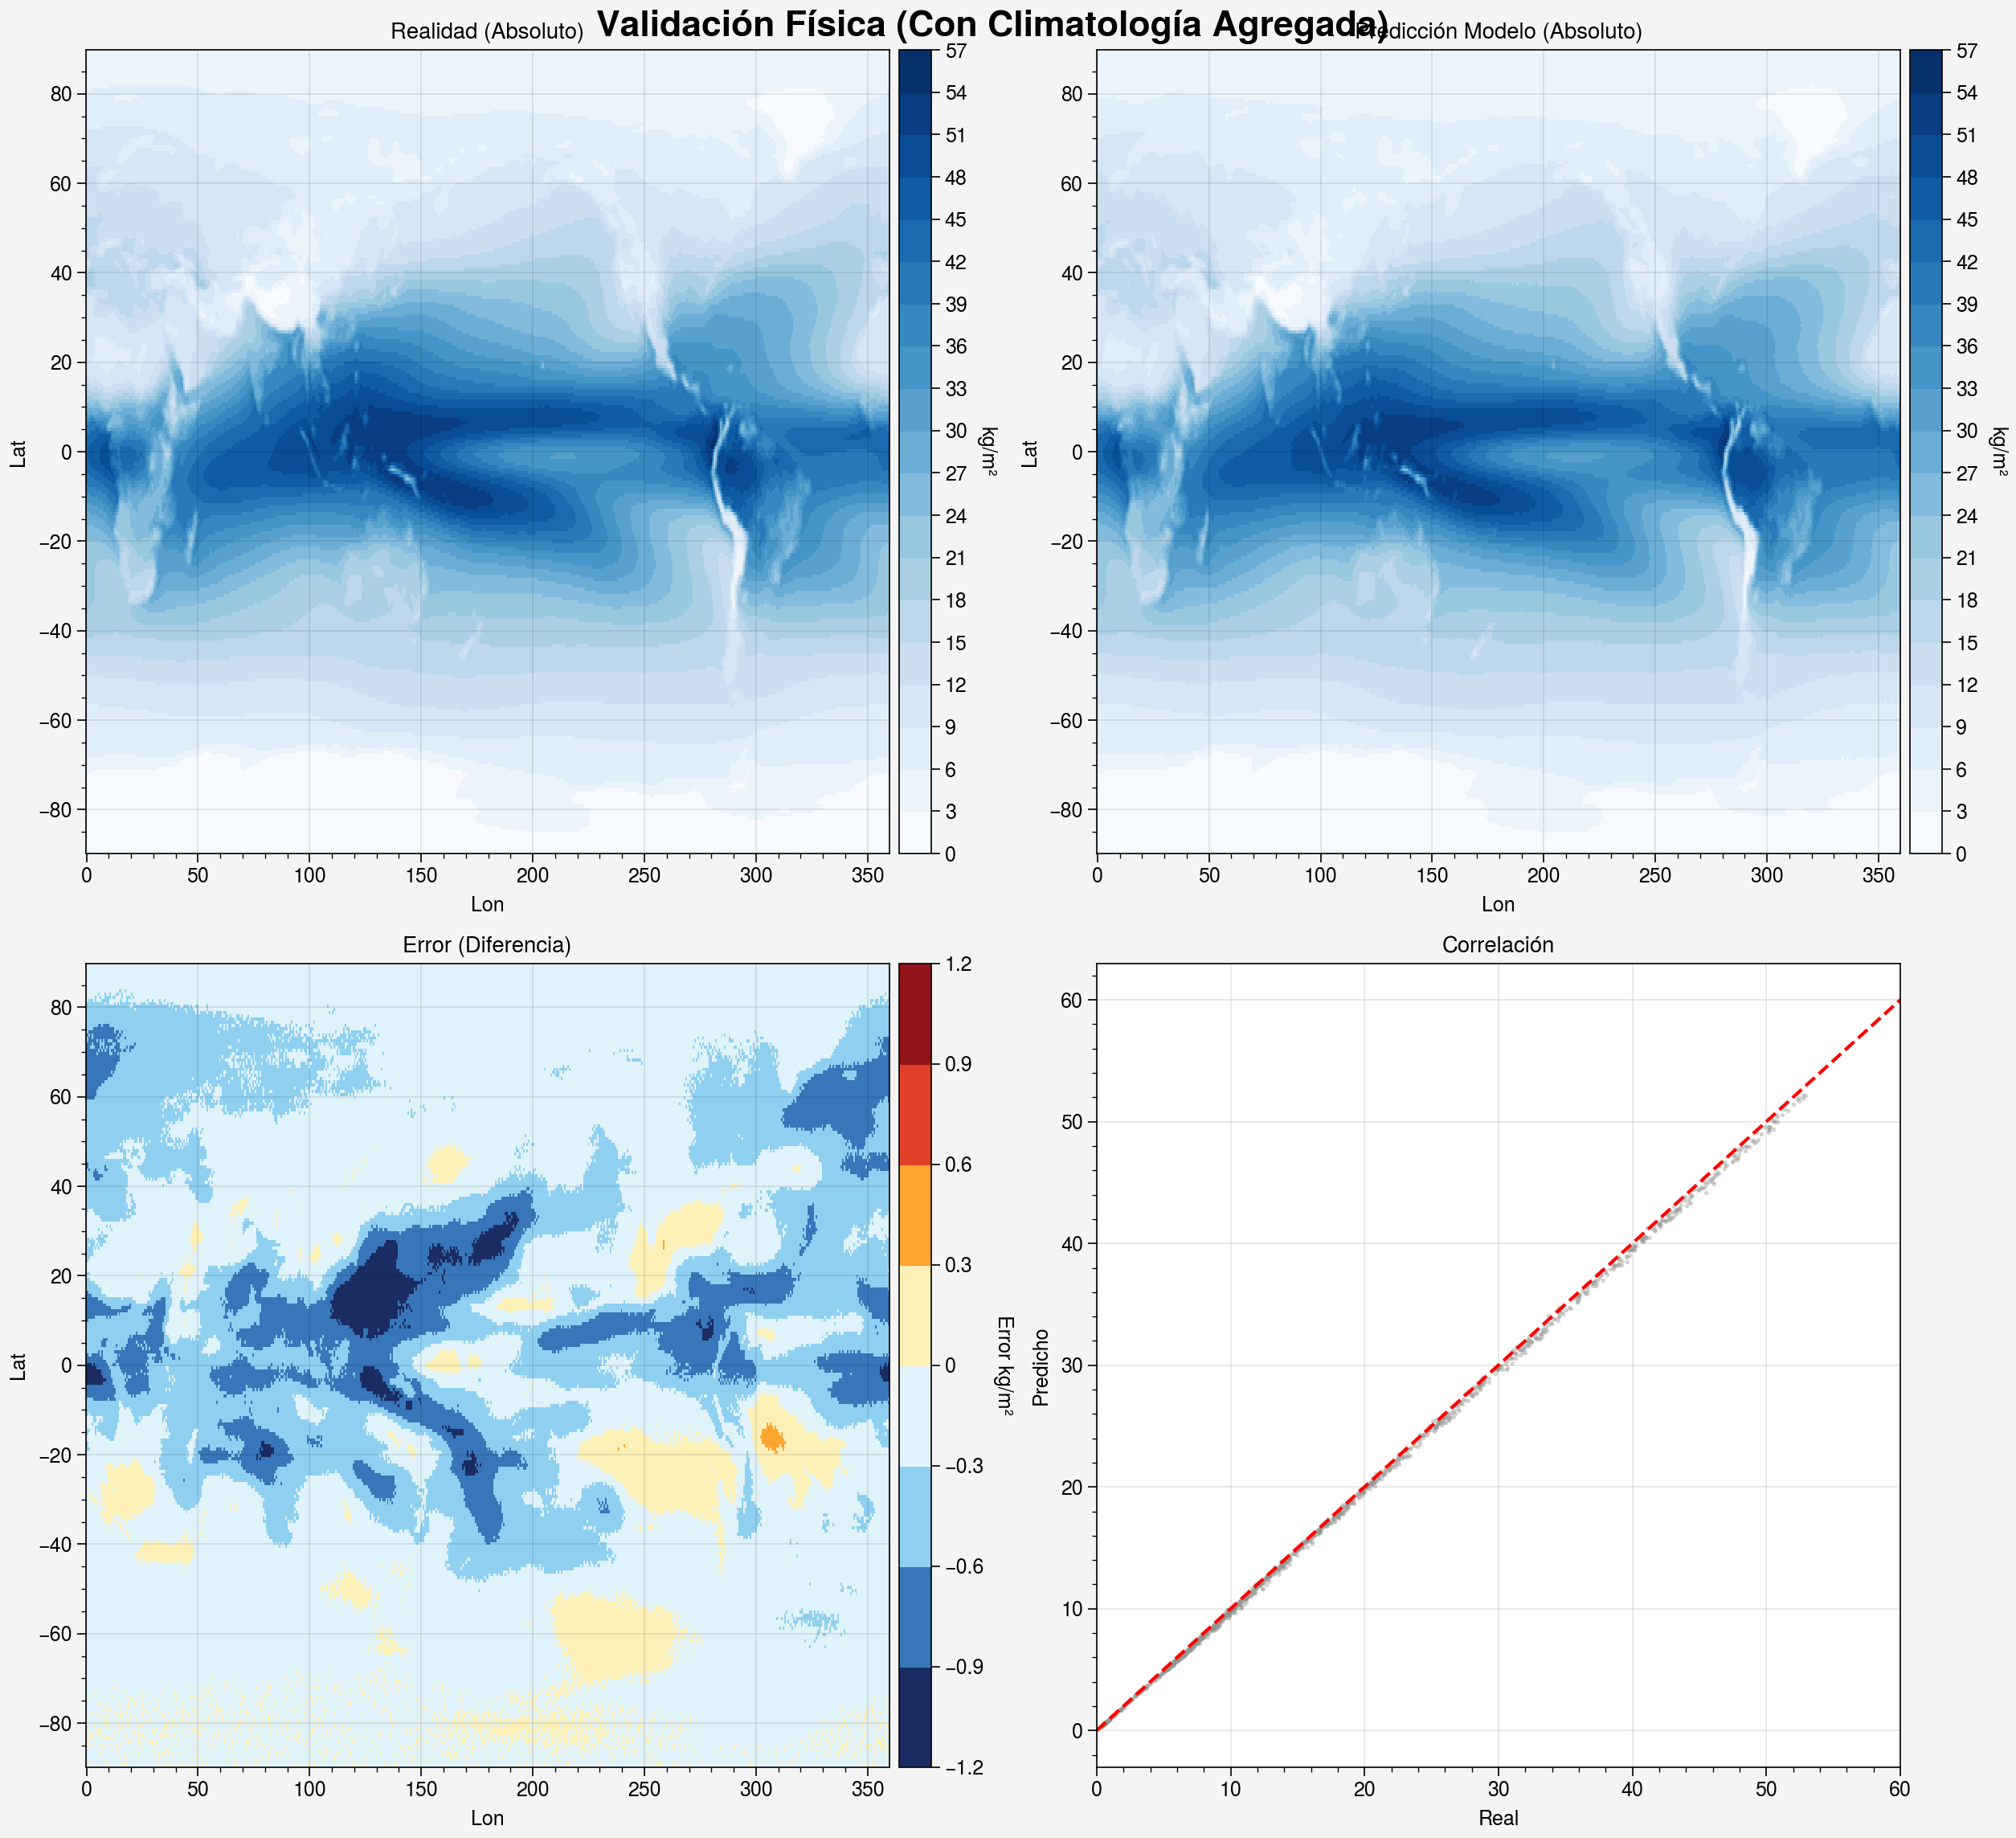

In [13]:
import sys
import os
import torch
import ultraplot as uplt
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

# --- CONFIGURACIÓN ---
current_dir = Path(os.path.abspath(''))
PROJECT_ROOT = current_dir.parent
sys.path.append(str(PROJECT_ROOT))

from src.model import ClimateEmulator

# AHORA USAMOS LOS ARCHIVOS DEL SPLIT 80/20
DATA_FILE = PROJECT_ROOT / "data" / "processed" / "val.pt"  # Usamos Validación
MODELS_DIR = PROJECT_ROOT / "outputs" / "models"
LOGS_FILE = PROJECT_ROOT / "outputs" / "logs" / "training_metrics.csv"

# --- 1. GRÁFICO DE MÉTRICAS (Diagnóstico) ---
if LOGS_FILE.exists():
    try:
        df = pd.read_csv(LOGS_FILE)
        fig, axs = uplt.subplots(ncols=2, share=False, refwidth=4)
        
        # Loss
        axs[0].plot(df['epoch'], df['train_loss'], label='Train', color='blue7')
        if 'val_loss' in df.columns:
            axs[0].plot(df['epoch'], df['val_loss'], label='Val', color='orange7', linestyle='--')
        axs[0].format(title='Convergencia', xlabel='Epochs', ylabel='Loss (MSE)', yscale='log')
        axs[0].legend(loc='ur')
        
        # R2
        if 'r2' in df.columns:
            axs[1].plot(df['epoch'], df['r2'], color='green7')
            axs[1].format(title='R² Score (Anomalías)', ylim=(-1, 1))
            axs[1].axhline(0, color='gray', linestyle='--')
        
        plt.show()
    except Exception as e:
        print(f"No se pudo graficar logs: {e}")

# --- 2. CARGAR MODELO Y DATOS ---
try:
    print(f"Cargando datos desde: {DATA_FILE}")
    data = torch.load(DATA_FILE)
    
    # Extraemos tensores (tomamos la primera muestra del set de validación para visualizar)
    # data['X'] tiene forma [N_muestras, Features]. Tomamos índice 0.
    idx = 0 
    X_sample = data['X'][idx].unsqueeze(0) 
    Y_sample = data['Y'][idx].unsqueeze(0)
    
    # Metadatos vitales
    coords = data['coords']
    scaler = data['scaler']
    climatology = data['climatology'].numpy() # ¡ESTO ES LO QUE FALTABA!
    
    # Cargar Modelo
    model_path = MODELS_DIR / "best_model.pth"
    model = ClimateEmulator(input_size=X_sample.shape[1])
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # --- 3. PREDICCIÓN ---
    print("Ejecutando prediccion...")
    with torch.no_grad():
        pred_anom_norm = model(X_sample)
        
    # --- 4. RECONSTRUCCIÓN FÍSICA (La parte importante) ---
    
    # A. Des-normalizar (Volver a Anomalías Reales)
    def denorm(t): return t.numpy().squeeze() * (scaler['max'] - scaler['min']) + scaler['min']
    
    Y_anom = denorm(Y_sample)
    Pred_anom = denorm(pred_anom_norm)
    
    # B. Sumar Climatología (Anomalía + Base = Valor Absoluto)
    # La climatología es 2D, los vectores son 1D.
    shape = (len(coords['lat']), len(coords['lon']))
    climatology_flat = climatology.flatten()
    
    # ¡AQUÍ ESTÁ LA MAGIA! SUMAMOS LA BASE
    Y_absolute = Y_anom + climatology_flat
    Pred_absolute = Pred_anom + climatology_flat
    
    # C. Reshape a 2D
    Y_map = Y_absolute.reshape(shape)
    Pred_map = Pred_absolute.reshape(shape)
    
    # El error se calcula mejor sobre las anomalías puras
    Error_map = (Pred_anom - Y_anom).reshape(shape)
    
    print("Datos reconstruidos correctamente.")

    # --- 5. GRAFICAR CON ULTRAPLOT ---
    fig, axs = uplt.subplots(nrows=2, ncols=2, share=0, refwidth=5)
    
    # A. Realidad
    m1 = axs[0].pcolormesh(coords['lon'], coords['lat'], Y_map, cmap='Blues', levels=20)
    axs[0].format(title='Realidad (Absoluto)', xlabel='Lon', ylabel='Lat')
    axs[0].colorbar(m1, label='kg/m²')
    
    # B. Predicción
    m2 = axs[1].pcolormesh(coords['lon'], coords['lat'], Pred_map, cmap='Blues', levels=20)
    axs[1].format(title='Predicción Modelo (Absoluto)', xlabel='Lon', ylabel='Lat')
    axs[1].colorbar(m2, label='kg/m²')
    
    # C. Error (Bias)
    limit = np.max(np.abs(Error_map))
    m3 = axs[2].pcolormesh(coords['lon'], coords['lat'], Error_map, cmap='ColdHot', vmin=-limit, vmax=limit)
    axs[2].format(title='Error (Diferencia)', xlabel='Lon', ylabel='Lat')
    axs[2].colorbar(m3, label='Error kg/m²')
    
    # D. Scatter (Usamos valores absolutos)
    axs[3].scatter(Y_absolute[::100], Pred_absolute[::100], s=2, alpha=0.3, color='gray')
    axs[3].plot([0, 60], [0, 60], color='red', linestyle='--')
    axs[3].format(title='Correlación', xlabel='Real', ylabel='Predicho')
    
    fig.suptitle('Validación Física (Con Climatología Agregada)', fontsize=16)
    plt.show()

except Exception as e:
    print(f"Error fatal: {e}")
    print("Consejo: Verifica que existan 'outputs/models/best_model.pth' y 'data/processed/val.pt'")